# Data loading

In [1]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean, stdev
from scipy.stats import multivariate_normal

In [2]:
jar = pd.read_csv('clean_data.csv')

fdData = [[] for _ in range(7)]
fdVals = jar['FD'].unique()

for i, val in enumerate(fdVals):
    fd = jar[jar['FD'] == val]
    fd = fd.drop(['FD', 'fuel_gas_swelling'], axis=1)
    fdData[i] = fd

In [3]:
lo_data = fdData[1]
hi_data = fdData[-1]

In [4]:
corr_mat = np.corrcoef(lo_data['fuel_swelling'].tolist(), hi_data['fuel_swelling'].tolist())
corr_mat

array([[1.        , 0.00705699],
       [0.00705699, 1.        ]])

# Lasso

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

In [6]:
feat_ind = list(range(7))
features = lo_data.iloc[:, feat_ind]
xscaler = StandardScaler()
X = xscaler.fit_transform(features)

In [7]:
reg1 = linear_model.Lasso(alpha=0.001)
reg2 = linear_model.Lasso(alpha=0.001)
reg3 = linear_model.Lasso(alpha=0.001)
reg4 = linear_model.Lasso(alpha=0.05)
reg5 = linear_model.Lasso(alpha=0.05)
reg6 = linear_model.Lasso(alpha=0.05)
reg7 = linear_model.Lasso(alpha=0.05)

reg = [reg1, reg2, reg3, reg4, reg5, reg6, reg7]

In [8]:
for data, mod in zip(fdData, reg):
    mod.fit(X, data['fuel_swelling'])
    print(mod.score(X, data['fuel_swelling']))
    #print(mod.coef_)

0.9926714106996755
0.9931141412007773
0.9929137007349252
0.9836908534204525
0.9943086784752904
0.9960245061565652
0.9969293137300165


In [9]:
lo_reg = reg2
hi_reg = reg7

In [10]:
print(lo_reg.coef_,
      hi_reg.coef_)

[-0.         -0.          0.         -0.04050914  0.01043899 -0.01058733
  0.02478742] [ 4.03026403 -2.45628912 -0.46216236 -0.          0.          0.
  0.        ]


# Multivariate target gaussian

In [11]:
def cr_multivar_gaussian(mu1, sig1, mu2, sig2, cov12):
    means = np.array([mu1, mu2])
    cov_matrix = np.array([[sig1**2, cov12],
                            [cov12, sig2**2]])
    mvn = multivariate_normal(mean=means, cov=cov_matrix)
    return mvn

In [12]:
def swelling_perc(fd):
    return 6.13e-43 * fd**2 + 4e-21 * fd

In [13]:
mu1 = swelling_perc(2e21)
mu2 = swelling_perc(7e21)
sig = 2.7
print(mu1-sig, mu1, mu1+sig)
print(mu2-sig, mu2, mu2+sig)

7.752 10.452 13.152000000000001
55.336999999999996 58.037 60.737


In [14]:
cov12 = 0.007
mvn = cr_multivar_gaussian(mu1, sig, mu2, sig, cov12)

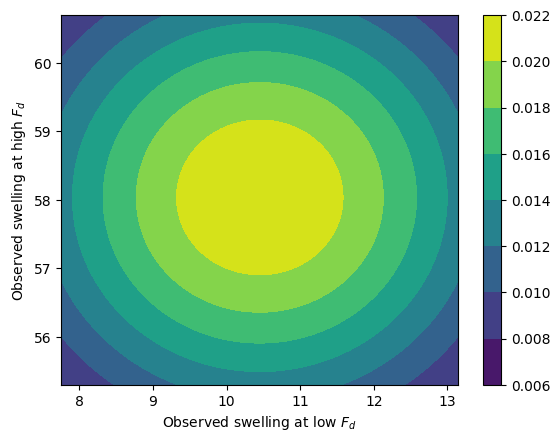

In [15]:
x, y = np.mgrid[7.75:13.15:0.01, 55.3:60.7:0.01]
pos = np.dstack((x, y))

fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.contourf(x, y, mvn.pdf(pos))
plt.colorbar(cs)

ax.set_xlabel(r"Observed swelling at low $F_d$")
ax.set_ylabel(r"Observed swelling at high $F_d$")
plt.show()

# MCMC sampler

In [16]:
def proposal_dist(X, sig):
    ret = []
    
    for el in X:
        prop = 6
        while (prop < -3 or prop > 3):
            prop = np.random.normal(el, sig)
        ret.append(prop)
        
    assert len(X) == len(ret)
    return ret

In [17]:
def mcmc_sampler(num_param, initial_state, proposal_sig,
                 surrogates, target_mvn, num_samples):
    samples = [initial_state]
    accepted = 0

    for ii in range(num_samples):
        current_state = samples[-1]
        proposed_state = proposal_dist(current_state, proposal_sig)

        fs1_curr = surrogates[0].predict([[*current_state]])[0]
        fs2_curr = surrogates[1].predict([[*current_state]])[0]
        
        fs1_prop = surrogates[0].predict([[*proposed_state]])[0]
        fs2_prop = surrogates[1].predict([[*proposed_state]])[0]
        
        acceptance_ratio = target_mvn.pdf([fs1_prop, fs2_prop]) / target_mvn.pdf([fs1_curr, fs2_curr])
        
        if np.random.rand() < acceptance_ratio:
            current_state = proposed_state
            accepted += 1

        samples.append(current_state)

    print(f"Acceptance rate: {accepted / num_samples}")
    return np.array(samples)

In [18]:
hey = mcmc_sampler(7, np.random.rand(7), 1.2, [lo_reg, hi_reg], mvn, 20000)

Acceptance rate: 0.5318


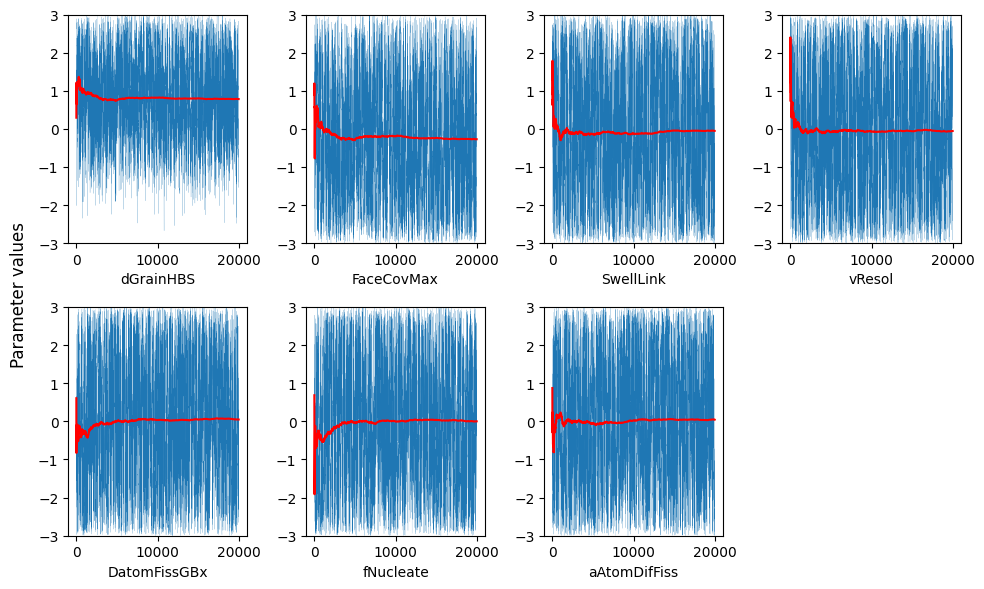

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()[:-1]):
    cdat = hey[:,i]
    cavg = np.cumsum(cdat) / np.arange(1, len(cdat)+1)
    ax.plot(cdat, lw=0.1, zorder=1)
    ax.plot(cavg, c='r', zorder=2)
    ax.set_xlabel(lo_data.columns[i])
    ax.set_ylim([-3, 3])

fig.delaxes(axes[1,3])
fig.supylabel('Parameter values')
plt.tight_layout()
plt.show()

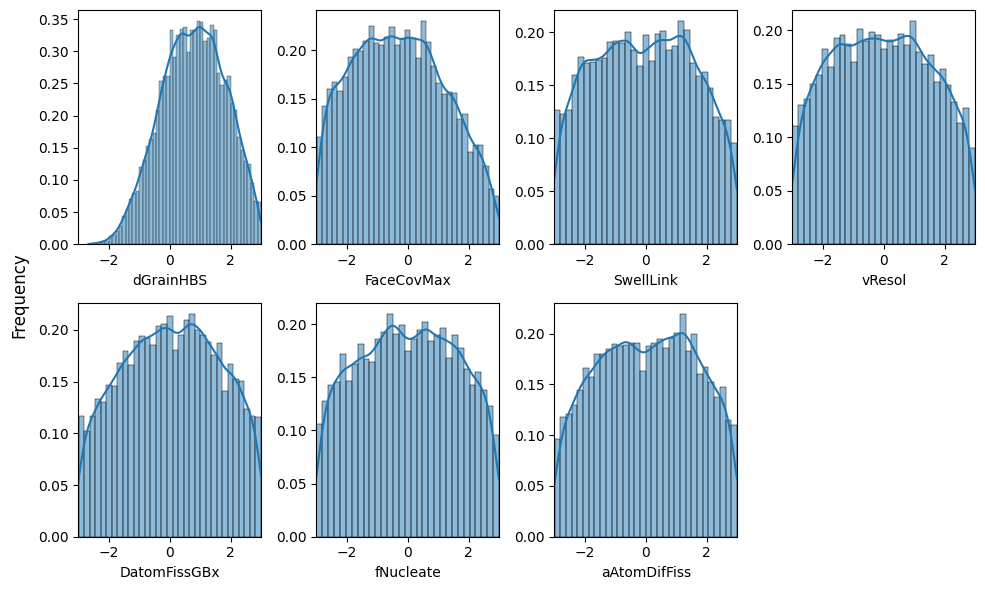

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()[:-1]):
    sns.histplot(hey[:,i], ax=ax, stat='density', kde=True)
    ax.set_xlabel(lo_data.columns[i])
    ax.set_ylabel('')
    ax.set_xlim([-3, 3])

fig.delaxes(axes[1,3])
fig.supylabel('Frequency')
plt.tight_layout()
plt.show()

# Forward propagation

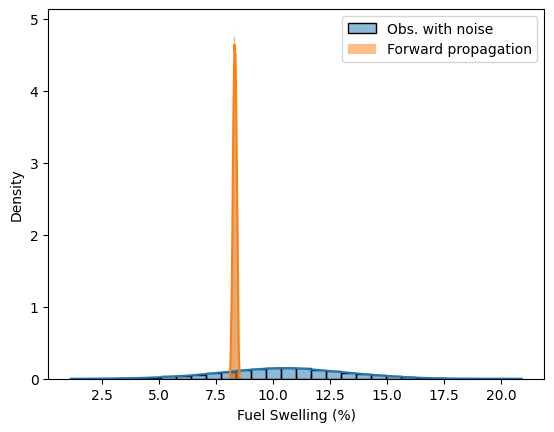

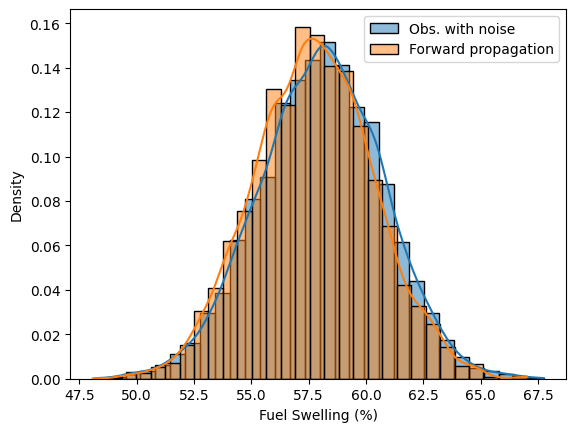

In [21]:
mus = [mu1, mu2]
sigs = [sig, sig]

for mod, mu, sig in zip([lo_reg, hi_reg], mus, sigs):
    orig = []
    res = []
    for i in range(10000):
        res.append(mod.predict([hey[-i]])[0])
        c = np.random.normal(mu, sig)
        orig.append(c)
        
    sns.histplot(orig, kde=True, bins=30, ec='k', stat='density', label='Obs. with noise')
    sns.histplot(res, kde=True, bins=30, ec='k', stat='density', label='Forward propagation')
    
    plt.xlabel('Fuel Swelling (%)')
    plt.legend()
    plt.show()

# Before and after IUQ

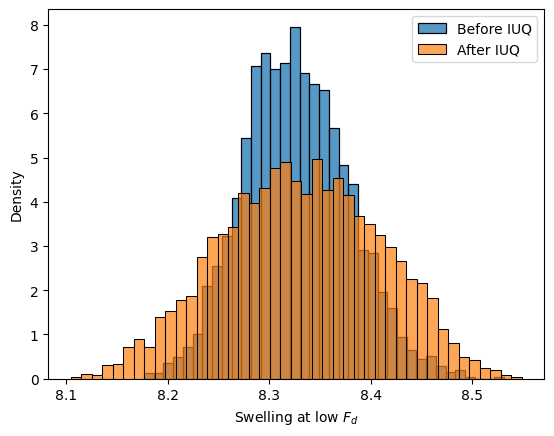

In [22]:
sns.histplot(lo_data['fuel_swelling'].tolist(),
             stat='density', label='Before IUQ')

res = []
for i in range(10000):
    res.append(lo_reg.predict([hey[-i]])[0])

sns.histplot(res, alpha=0.7, stat='density', label='After IUQ')

plt.xlabel(r'Swelling at low $F_d$')
plt.legend()
plt.show()

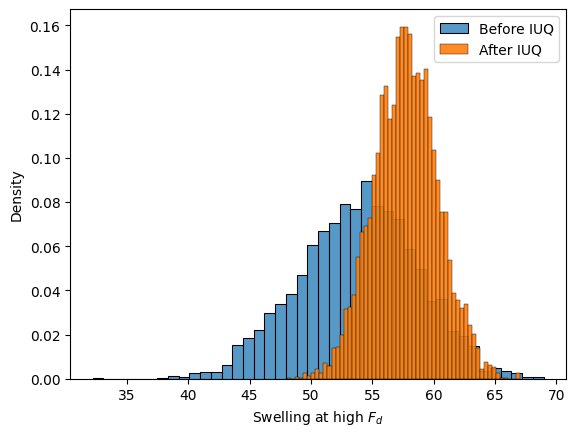

In [23]:
sns.histplot(hi_data['fuel_swelling'].tolist(),
             stat='density', label='Before IUQ')

res = []
for i in range(10000):
    res.append(hi_reg.predict([hey[-i]])[0])

sns.histplot(res, alpha=0.9, stat='density', label='After IUQ')

plt.xlabel(r'Swelling at high $F_d$')
plt.legend()
plt.show()

# Whole lotta love

In [24]:
modPred = [[] for _ in range(7)]

for jj, mod in enumerate(reg):
    for i in range(10000):
        modPred[jj].append(mod.predict([hey[-i]])[0])

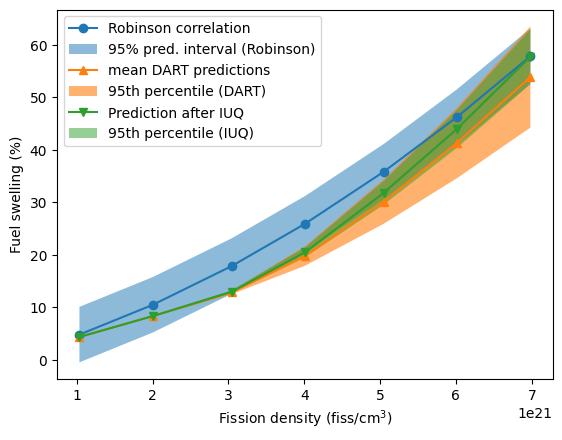

In [25]:
# experiment
y_exp = [swelling_perc(x) for x in fdVals]

plt.plot(fdVals, y_exp, marker='o',
         label='Robinson correlation')
exp_hi = [y + 5.28 for y in y_exp]
exp_lo = [y - 5.28 for y in y_exp]
plt.fill_between(fdVals, exp_lo, exp_hi, alpha=0.5,
                 label='95% pred. interval (Robinson)')

# prior
y_mod = []
e_mod = []
for x, data in zip(fdVals, fdData):
    y_mod.append(mean(data['fuel_swelling']))
    e_mod.append(stdev(data['fuel_swelling']))

plt.plot(fdVals, y_mod, marker='^',
         label='mean DART predictions')
mod_hi = [i + 2*j for i, j in zip(y_mod, e_mod)]
mod_lo = [i - 2*j for i, j in zip(y_mod, e_mod)]
plt.fill_between(fdVals, mod_lo, mod_hi, alpha=0.6,
                 label='95th percentile (DART)')

# posterior
y_mod = []
e_mod = []
for pred in modPred:
    y_mod.append(mean(pred))
    e_mod.append(stdev(pred))

plt.plot(fdVals, y_mod, marker='v',
         label='Prediction after IUQ')
mod_hi = [i + 2*j for i, j in zip(y_mod, e_mod)]
mod_lo = [i - 2*j for i, j in zip(y_mod, e_mod)]
plt.fill_between(fdVals, mod_lo, mod_hi, alpha=0.5,
                 label='95th percentile (IUQ)')

plt.xlabel(r'Fission density (fiss/cm$^3$)')
plt.ylabel('Fuel swelling (%)')

plt.legend()
plt.show()